In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm
from PIL import Image
import os
import shutil
import json
import io

# Inspect full image archive without extracting all files

In [3]:
root_path = '../../../train/image/'
filenames = []
paths = []
for file in os.listdir(root_path)[:]:
    if 'jpg' in file:
        filenames.append(file)
        paths.append(root_path + file)
df = pd.DataFrame({'filename': filenames, 'path': paths})
print(len(df))
df.sample(n=5)

191952


,filename,path
11243,128932.jpg,../../../train/image/128932.jpg
19194,095598.jpg,../../../train/image/095598.jpg
59287,040707.jpg,../../../train/image/040707.jpg
53060,158692.jpg,../../../train/image/158692.jpg
185334,076206.jpg,../../../train/image/076206.jpg


# Basic EDA


### Inspect a few sample images and corresponding bounding boxes

In [4]:
samples = df['path'].sample(5)
annos = []
bboxes = []
images = []
for file in samples: 
    anno = open(file.replace('.jpg','.json').replace('/image/','/annos/')).read()
    anno = json.loads(anno)
    annos.append(anno)
    
    bbox = anno['item1']['bounding_box']
    bboxes.append(bbox)
    
    img = Image.open(file)
    images.append(img)

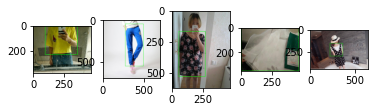

In [5]:
fig, ax = plt.subplots(1,len(samples))
i=0
for img, bbox in zip(images, bboxes):
    (x1, y1, x2, y2) = bbox
    img_bbox = cv2.rectangle(np.array(img), (x1, y1), (x2, y2), (0, 255, 0), 2)
    ax[i].imshow(img_bbox)
    i+=1
plt.show()

### Examine classes

In [6]:
%%time
ids = []
sources = []
scales = []
viewpoints = []
zooms = []
occlusions = []
landmarks = []
bboxes = []
styles = []
category_ids = []
category_names = []
annos = [f.replace('image', 'annos').replace('jpg', 'json') for f in df['path']]
print('# rows', len(annos))
for file in tqdm(annos): 
    anno = open(file).read()
    anno = json.loads(anno)
    
    for key in anno.keys():
        if 'item' in key:
            ids.append(file.split('/')[-1].split('.')[0])
            sources.append(anno['source'])
            #anno.keys() => dict_keys(['segmentation', 'scale', 'viewpoint', 'zoom_in', 'landmarks', 'style', 'bounding_box', 'category_id', 'occlusion', 'category_name'])
            scales.append(anno[key]['scale'])
            viewpoints.append(anno[key]['viewpoint'])
            zooms.append(anno[key]['zoom_in'])
            occlusions.append(anno[key]['occlusion'])
            landmarks.append(anno[key]['landmarks'])
            bboxes.append(anno[key]['bounding_box'])
            styles.append(anno[key]['style'])
            category_ids.append(anno[key]['category_id'])
            category_names.append(anno[key]['category_name'])    

# rows 191952


  0%|          | 0/191952 [00:00<?, ?it/s]

CPU times: user 14.1 s, sys: 1.75 s, total: 15.8 s
Wall time: 51 s


In [7]:
df_meta_all = pd.DataFrame(data=zip(ids, sources, scales, viewpoints, zooms, occlusions, landmarks, bboxes, styles, category_ids, category_names), columns=['id', 'source', 'scale', 'viewpoint', 'zoom', 'occlusion', 'landmarks', 'bbox', 'style', 'category_id', 'category_name'])
print(len(df_meta_all))
df_meta_all[:5]

312170


,id,source,scale,viewpoint,zoom,occlusion,landmarks,bbox,style,category_id,category_name
0,064031,user,3,3,2,1,"[210, 293, 1, 120, 292, 1, 177, 311, 2, 241, 3...","[17, 254, 442, 623]",1,10,short sleeve dress
1,092154,shop,2,2,3,2,"[359, 396, 1, 434, 382, 1, 484, 335, 1, 372, 4...","[354, 303, 571, 499]",0,8,trousers
2,092154,shop,2,2,1,2,"[336, 153, 1, 293, 177, 1, 324, 188, 2, 358, 1...","[255, 133, 501, 415]",2,1,short sleeve top
3,077378,shop,1,2,1,2,"[266, 375, 1, 317, 377, 2, 382, 362, 1, 279, 5...","[254, 359, 397, 703]",1,9,skirt
4,077378,shop,1,2,1,3,"[292, 227, 1, 265, 230, 1, 276, 238, 1, 301, 2...","[211, 191, 413, 395]",0,1,short sleeve top


In [8]:
df_meta = df_meta_all.copy()

## Reference:  https://github.com/switchablenorms/DeepFashion2

Key fields:

- source: a string, where 'shop' indicates that the image is from commercial store while 'user' indicates that the image is taken by users.

- scale: a number, where 1 represents small scale, 2 represents modest scale and 3 represents large scale.

- occlusion: a number, where 1 represents slight occlusion(including no occlusion), 2 represents medium occlusion and 3 represents heavy occlusion.

- zoom_in: a number, where 1 represents no zoom-in, 2 represents medium zoom-in and 3 represents lagre zoom-in.

- viewpoint: a number, where 1 represents no wear, 2 represents frontal viewpoint and 3 represents side or back viewpoint.

First pass of training YOLOv5 on DF1 indicates that results including 'user' photos is very poor due to extreme viewing angles (down in mirror at jeans), heavy occlusion, etc.

Therefore, now filtering out 'poor quality' images.

In [9]:
if False:
    df_meta = df_meta[(df_meta.source=='shop') & (df_meta.scale>1) & 
                  (df_meta.occlusion<2) & (df_meta.zoom<2) & 
                  (df_meta.viewpoint<3)]

In [10]:
cnts = df_meta.groupby('category_name').count().sort_values(by='id', ascending=False)
cnts

,id,source,scale,viewpoint,zoom,occlusion,landmarks,bbox,style,category_id
category_name,,,,,,,,,,
short sleeve top,71641,71641,71641,71641,71641,71641,71641,71641,71641,71641
trousers,55385,55385,55385,55385,55385,55385,55385,55385,55385,55385
shorts,36612,36612,36612,36612,36612,36612,36612,36612,36612,36612
long sleeve top,36062,36062,36062,36062,36062,36062,36062,36062,36062,36062
skirt,30834,30834,30834,30834,30834,30834,30834,30834,30834,30834
vest dress,17948,17948,17948,17948,17948,17948,17948,17948,17948,17948
short sleeve dress,17210,17210,17210,17210,17210,17210,17210,17210,17210,17210
vest,16094,16094,16094,16094,16094,16094,16094,16094,16094,16094
long sleeve outwear,13457,13457,13457,13457,13457,13457,13457,13457,13457,13457


In [11]:
# filtering out categories with fewer than 5,000 samples
cats = cnts[cnts.id > 5000].index.values
cats

array(['short sleeve top', 'trousers', 'shorts', 'long sleeve top',
       'skirt', 'vest dress', 'short sleeve dress', 'vest',
       'long sleeve outwear', 'long sleeve dress', 'sling dress'],
      dtype=object)

In [12]:
subset = df_meta[df_meta.category_name.isin(cats)]

In [13]:
min_cnt = subset.groupby('category_name').count().min()[0]
min_cnt

6492

In [14]:
# Setting sample count at 5,000 per category to balance across categories, 
# and to leave 'unseen' samples available to create a custom "TEST" dataset
#samples = subset.groupby('category_name').sample(n=5000, random_state=314)

# for the full dataset we keep everythig
samples = subset

len(samples)

309642

In [15]:
df['id'] = df['filename'].apply(lambda x: x.split('.')[0])

In [16]:
#from sklearn.model_selection import train_test_split
#train, val = train_test_split(samples, test_size=0.2)
#print(len(train),len(val))

#For this case, all the data is in the training set
train = samples

In [17]:
#val = pd.merge(df, val, on='id')
#val = val[val.folder=='image']
#len(val)

In [20]:
train = pd.merge(df, train, on='id')
len(train)

309642

In [21]:
train.iloc[0]

filename_x                                              064031.jpg
path_x                             ../../../train/image/064031.jpg
id                                                          064031
filename_y                                              064031.jpg
path_y                             ../../../train/image/064031.jpg
source                                                        user
scale                                                            3
viewpoint                                                        3
zoom                                                             2
occlusion                                                        1
landmarks        [210, 293, 1, 120, 292, 1, 177, 311, 2, 241, 3...
bbox                                           [17, 254, 442, 623]
style                                                            1
category_id                                                     10
category_name                                   short sleeve d

In [22]:
root = '../../../'

if not os.path.exists(root+'df2_all'):
    os.mkdir(root+'df2_all')

if not os.path.exists(root+'df2_all/images'):
    os.mkdir(root+'df2_all/images')
if not os.path.exists(root+'df2_all/images/train'):
    os.mkdir(root+'df2_all/images/train')
if not os.path.exists(root+'df2_all/images/val'):
    os.mkdir(root+'df2_all/images/val')
if not os.path.exists(root+'df2_all/images/test'):
    os.mkdir(root+'df2_all/images/test')


if not os.path.exists(root+'df2_all/labels'):
    os.mkdir(root+'df2_all/labels')
if not os.path.exists(root+'df2_all/labels/train'):
    os.mkdir(root+'df2_all/labels/train')
if not os.path.exists(root+'df2_all/labels/val'):
    os.mkdir(root+'df2_all/labels/val')
if not os.path.exists(root+'df2_all/labels/test'):
    os.mkdir(root+'df2_all/labels/test')

In [40]:
target_dim = 640.0
 
def createFiles(data=train, type_='train'):
    for i, row in data.iterrows():
        if i%int(len(data)/100)==0:
            print(i)
        try:
            filepath = row.path_x
            img = Image.open(filepath)
            w_orig = float(img.size[0])
            h_orig = float(img.size[1])
            img.thumbnail((target_dim, target_dim)) 
            if 'png' in str(type(img)).lower():
                img = img.convert('RGB')
            img.save(root+'df2_all/images/'+type_+'/'+row.filename_x, 'JPEG', optimize=True)

            (x1, y1, x2, y2) = [float(b) for b in row.bbox]
            x = round((((x2 - x1)/2) + x1) / w_orig, 4)
            y = round((((y2 - y1)/2) + y1) / h_orig, 4)
            w = round((x2 - x1) / w_orig, 4)
            h = round((y2 - y1) / h_orig, 4)

            idx = list(cats).index(row.category_name)
            metadata = str(idx) + f' {x} {y} {w} {h}'
            fileroot = root+'df2_all/labels/'+type_+'/'+row.filename_x.split('.')[0]+'.txt'

            f = open(fileroot, 'w')
            f.write(metadata)
            f.close()
            img = None
        except:
            print('error:', row.path_x)

In [41]:
createFiles(train, type_='train')
#createFiles(val, type_='val')

0
3096
6192
9288
12384
15480
18576
21672
24768
27864
30960
34056
37152
40248
43344
46440
49536
52632
55728
58824
61920
65016
68112
71208
error: ../../../train/image/123236.jpg
error: ../../../train/image/123236.jpg
74304
77400
80496
83592
86688
89784
92880
95976
99072
102168
105264
108360
111456
114552
117648
120744
123840
126936
130032
133128
136224
139320
142416
145512
148608
151704
154800
157896
160992
164088
167184
170280
173376
176472
179568
182664
185760
188856
191952
195048
198144
201240
error: ../../../train/image/121049.jpg
error: ../../../train/image/121049.jpg
204336
207432
210528
213624
216720
219816
222912
226008
229104
232200
235296
238392
241488
244584
247680
250776
253872
256968
error: ../../../train/image/095882.jpg
260064
263160
266256
269352
272448
275544
278640
281736
284832
287928
291024
294120
297216
300312
303408
306504
309600


In [42]:
lines = []
lines.append('path: ../df2_all # root dir\n')
lines.append('train: images/train\n')
lines.append('val: images/val\n')
lines.append('test:  images/test\n')

lines.append('nc: '+str(len(cats))+' # number of classes\n')

str_classes = "[ '" + "',\n'".join(cats) + "' ]"

lines.append('names: '+str_classes + '\n')

f = open(root+'df2_all/df2_all.yaml', 'w')
f.writelines(lines)
f.close()